1 Checking the correlation between variables

                      no   Room1_G   Room2_B   Room3_Y   Room3_O  \
no              1.000000  0.163864 -0.255880 -0.220561  0.350401   
Room1_G         0.163864  1.000000  0.005106 -0.109942 -0.022979   
Room2_B        -0.255880  0.005106  1.000000  0.036166 -0.032004   
Room3_Y        -0.220561 -0.109942  0.036166  1.000000 -0.064057   
Room3_O         0.350401 -0.022979 -0.032004 -0.064057  1.000000   
3_state(total)  0.004450  0.147205  0.124914  0.127849 -0.112804   
1_state(total)  0.156708  0.130997 -0.040974  0.093104 -0.072620   
2_state(total) -0.028856  0.036416  0.140782  0.166176 -0.103395   

                3_state(total)  1_state(total)  2_state(total)  
no                    0.004450        0.156708       -0.028856  
Room1_G               0.147205        0.130997        0.036416  
Room2_B               0.124914       -0.040974        0.140782  
Room3_Y               0.127849        0.093104        0.166176  
Room3_O              -0.112804       -0.072620       -0.103395

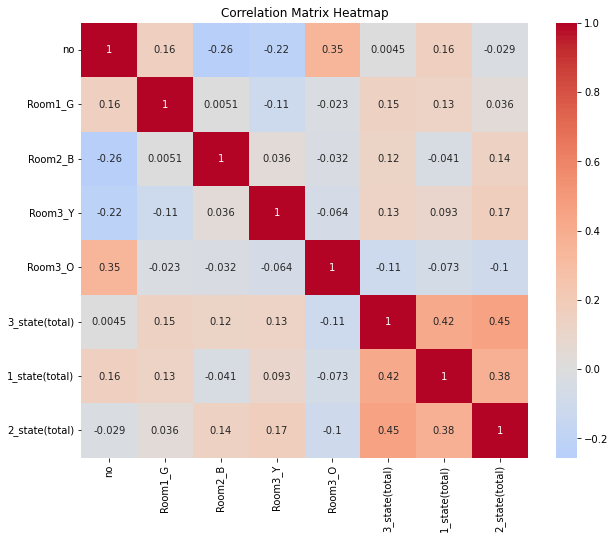

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# read data
df = pd.read_csv('all_modified.csv')

# calculate correlation for each variables
correlation_matrix = df.corr()

print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

From this chart, we can observe that there isn't a strong linear relationship between the noise sensor data and the seat occupancy in each room on an hourly basis. However, the chart reveals an interesting phenomenon: there is a certain degree of linear correlation among the seat occupancy counts in the three rooms. In other words, when the number of seat occupancies increases in one room, the number of seat occupancies in other rooms also tends to increase. credit to https://github.com/huanfachen/QM_2021/blob/main/practicals/Practical-04-advanced_regression.ipynb

在看过两者的线性关系后，接下来，我们选取应用Granger因果性检验来判断两个变量之间是否可以相互预测。首先看其时间序列趋势。

2.1 Time Series

In [1]:
print(df)

In [2]:
%matplotlib inline
from matplotlib.pylab import plt

import pandas as pd
import numpy as np
import statsmodels

import statsmodels
print(statsmodels.__version__)
print(np.__version__)
print(pd.__version__)

0.13.2
1.23.3
1.4.3


In [3]:
df = pd.read_csv("all_modified.csv", header = 0, parse_dates = [0], index_col = 0)

In [4]:
df.head()

,time,Room1_G,Room2_B,Room3_Y,Room3_O,3_state(total),1_state(total),2_state(total)
no,,,,,,,,
1,01/06/2023 09:00,39.0,59.45,50.25,39.0,0,0,8
2,01/06/2023 10:00,39.0,59.15,50.75,39.0,7,1,6
3,01/06/2023 11:00,39.0,54.40,51.15,39.0,9,1,4
4,01/06/2023 12:00,39.0,55.00,50.70,62.3,8,0,2
5,01/06/2023 13:00,39.0,55.60,50.70,85.6,7,1,2


In [5]:
#df['2023-06-01 09:00:00':'2023-06-17 20:00:00']

In [6]:
# 假设'datetime'是你的日期时间列名
df.set_index('time', inplace=True)

# 对DatetimeIndex进行排序
df.sort_index(inplace=True)

# 假设你想选择'2023-06-01 09:00:00'到'2023-06-17 20:00:00'这个时间范围内的数据
selected_df = df.loc['2023-06-01 09:00:00':'2023-06-17 20:00:00']

# 查看选择的数据
print(selected_df)


Empty DataFrame
Columns: [Room1_G, Room2_B, Room3_Y, Room3_O, 3_state(total), 1_state(total), 2_state(total)]
Index: []


<AxesSubplot:xlabel='time'>

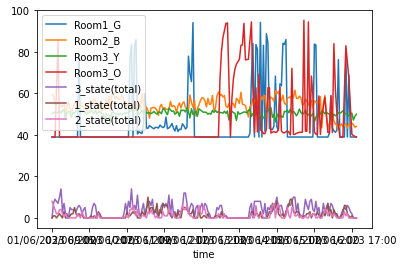

In [7]:
df.plot()

### is it stationary: mean, variance, autocovariance do not depend on time

<AxesSubplot:xlabel='time'>

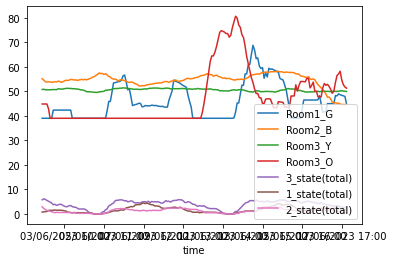

In [8]:
# first test, informally, plot the moving average
# note the ROLLING function, 12 means every 12 hours is one loop(working time)
df.rolling(window = 12).mean().plot()

In [9]:
from statsmodels.tsa.stattools import adfuller

# next more formally apply the Augmented Dickey-Fuller test
columns_to_test = ['Room1_G', 'Room2_B', 'Room3_Y', 'Room3_O', '3_state(total)', '1_state(total)', '2_state(total)']

for column in columns_to_test:
    result = adfuller(df[column], autolag='AIC', regression='ct')
    
    print(f'Results for {column}:')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Used lags: %i' % result[2])
    print('Number of observations used: %i' % result[3])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print()



Results for Room1_G:
ADF Statistic: -6.591043
p-value: 0.000000
Used lags: 1
Number of observations used: 202
Critical values:
	1%: -4.004
	5%: -3.432
	10%: -3.140

Results for Room2_B:
ADF Statistic: -2.439919
p-value: 0.358621
Used lags: 2
Number of observations used: 201
Critical values:
	1%: -4.005
	5%: -3.433
	10%: -3.140

Results for Room3_Y:
ADF Statistic: -6.066443
p-value: 0.000002
Used lags: 5
Number of observations used: 198
Critical values:
	1%: -4.005
	5%: -3.433
	10%: -3.140

Results for Room3_O:
ADF Statistic: -2.690121
p-value: 0.240207
Used lags: 8
Number of observations used: 195
Critical values:
	1%: -4.006
	5%: -3.433
	10%: -3.140

Results for 3_state(total):
ADF Statistic: -3.234386
p-value: 0.077765
Used lags: 8
Number of observations used: 195
Critical values:
	1%: -4.006
	5%: -3.433
	10%: -3.140

Results for 1_state(total):
ADF Statistic: -2.344605
p-value: 0.409452
Used lags: 9
Number of observations used: 194
Critical values:
	1%: -4.006
	5%: -3.433
	10%: -3.1

Then make my data stationary

In [10]:
# One method to get rid of time varying variance is to do a power or log transformation that punishes larger values
# more than smaller values
#log_df = df.apply(lambda x: np.log(x))
#log_df.plot()

<AxesSubplot:xlabel='time'>

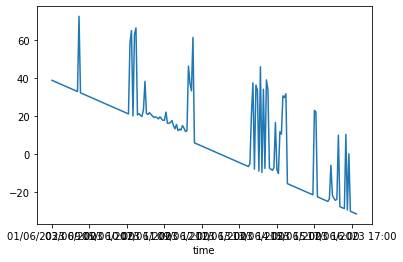

In [11]:
# Now let's use a regression rather than a rolling mean to detrend
from statsmodels.regression.linear_model import OLS
model = OLS(df.Room1_G.values, list(range(len(df.values))))
result = model.fit()
result.params
fit = pd.Series(result.predict(list(range(len(df.values)))), index = df.index)

df_detrended = df.Room1_G - fit
df_detrended.plot()

Results for Room1_G:
[0.34656858]
Results for Room2_B:
[0.39551834]
Results for Room3_Y:
[0.37119554]
Results for Room3_O:
[0.37076056]
Results for 3_state(total):
[0.02838973]
Results for 1_state(total):
[0.01376804]
Results for 2_state(total):
[0.00924313]


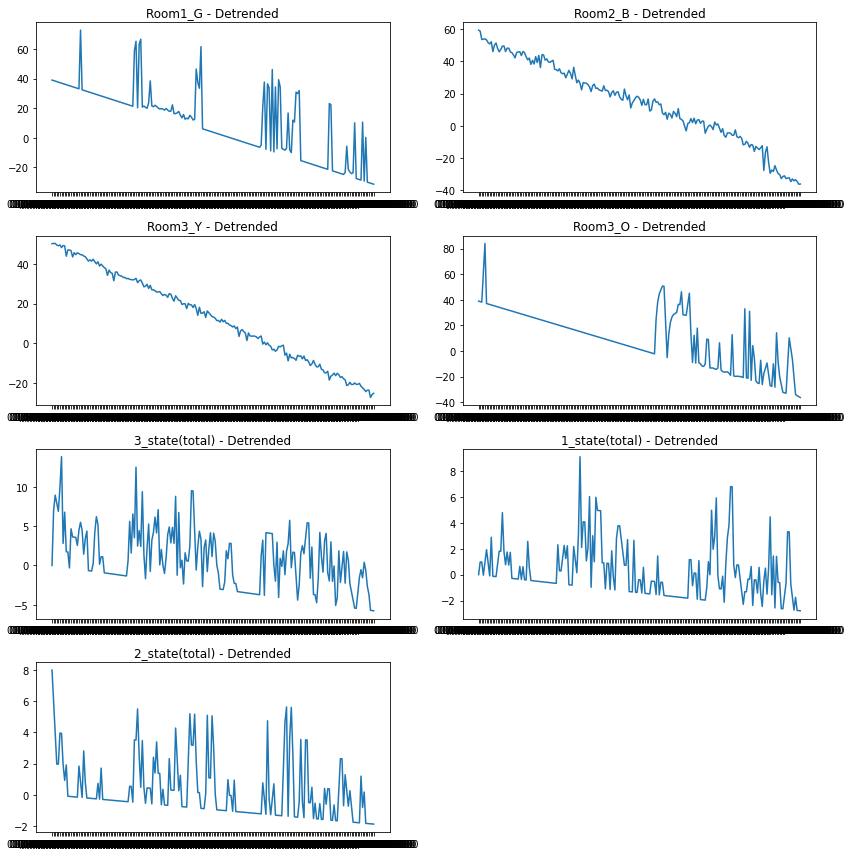

In [12]:
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS

variables = ['Room1_G', 'Room2_B', 'Room3_Y', 'Room3_O', '3_state(total)', '1_state(total)', '2_state(total)']

fig, axs = plt.subplots(len(variables)//2 + len(variables)%2, 2, figsize=(12,12))

# Remove unused subplots
if len(variables) % 2:
    fig.delaxes(axs[len(variables)//2, 1])

for ax, var in zip(axs.flatten(), variables):
    model = OLS(df[var].values, list(range(len(df.values))))
    result = model.fit()
    print(f"Results for {var}:")
    print(result.params)
    fit = pd.Series(result.predict(list(range(len(df.values)))), index = df.index)

    df_detrended = df[var] - fit
    ax.plot(df_detrended)
    ax.set_title(f"{var} - Detrended")

plt.tight_layout()
plt.show()



回归其实更通用，也更适合存在非线性关系的数据，使其对于假设检验和因果推理非常有用。然而，由于自相关和非平稳性等问题，对时间序列数据使用回归需要特别小心。该模型的性能取决于其假设的满足程度。从图中可以看出噪音数据的趋势性还很强，还需要进行差分等去趋势化操作，占用数据趋势性较弱。

# Seasonality

### Differencing

In [13]:
print(df)

                  Room1_G  Room2_B  Room3_Y  Room3_O  3_state(total)  \
time                                                                   
01/06/2023 09:00     39.0    59.45    50.25   39.000               0   
01/06/2023 10:00     39.0    59.15    50.75   39.000               7   
01/06/2023 11:00     39.0    54.40    51.15   39.000               9   
01/06/2023 12:00     39.0    55.00    50.70   62.300               8   
01/06/2023 13:00     39.0    55.60    50.70   85.600               7   
...                   ...      ...      ...      ...             ...   
17/06/2023 16:00     39.0    44.60    50.10   53.775               3   
17/06/2023 17:00     39.0    45.70    50.50   40.300               2   
17/06/2023 18:00     39.0    45.00    47.15   39.650               0   
17/06/2023 19:00     39.0    43.70    49.05   39.325               0   
17/06/2023 20:00     39.0    44.20    50.00   39.000               0   

                  1_state(total)  2_state(total)  
time        

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

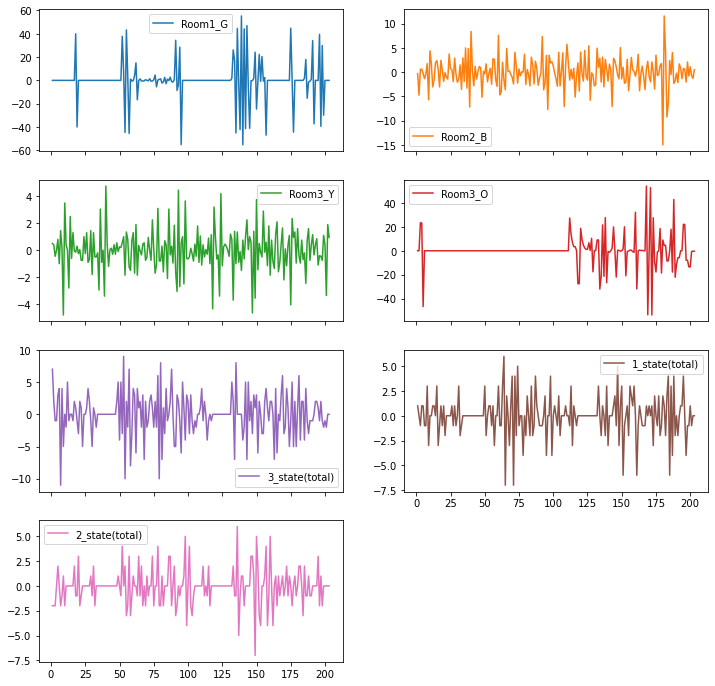

In [40]:

# 获取一阶差分
df_diff = df.apply(lambda x: x - x.shift())
# 绘制每一列的一阶差分
df_diff.plot(subplots=True, layout=(4, 2), figsize=(12, 12))


In [15]:
print(df_diff)
df_diff.to_csv("df_diff.csv")



                  Room1_G  Room2_B  Room3_Y  Room3_O  3_state(total)  \
time                                                                   
01/06/2023 09:00      NaN      NaN      NaN      NaN             NaN   
01/06/2023 10:00      0.0    -0.30     0.50    0.000             7.0   
01/06/2023 11:00      0.0    -4.75     0.40    0.000             2.0   
01/06/2023 12:00      0.0     0.60    -0.45   23.300            -1.0   
01/06/2023 13:00      0.0     0.60     0.00   23.300            -1.0   
...                   ...      ...      ...      ...             ...   
17/06/2023 16:00    -29.9    -0.80     1.10  -13.475            -2.0   
17/06/2023 17:00      0.0     1.10     0.40  -13.475            -1.0   
17/06/2023 18:00      0.0    -0.70    -3.35   -0.650            -2.0   
17/06/2023 19:00      0.0    -1.30     1.90   -0.325             0.0   
17/06/2023 20:00      0.0     0.50     0.95   -0.325             0.0   

                  1_state(total)  2_state(total)  
time        

In [35]:
from statsmodels.tsa.stattools import adfuller

# next more formally apply the Augmented Dickey-Fuller test
#columns_to_test = ['Room1_G', 'Room2_B', 'Room3_Y', 'Room3_O', '3_state(total)', '1_state(total)', '2_state(total)']

for column in df_diff:
    result_diff = adfuller(df_diff[column], autolag='AIC', regression='ct')
    
    print(f'Results for {column}:')
    print('ADF Statistic: %f' % result_diff[0])
    print('p-value: %f' % result_diff[1])
    print('Used lags: %i' % result_diff[2])
    print('Number of observations used: %i' % result_diff[3])
    print('Critical values:')
    for key, value in result_diff[4].items():
        print('\t%s: %.3f' % (key, value))
    print()

Results for Room1_G:
ADF Statistic: -25.800566
p-value: 0.000000
Used lags: 0
Number of observations used: 668
Critical values:
	1%: -3.972
	5%: -3.417
	10%: -3.131

Results for Room2_B:
ADF Statistic: -19.142215
p-value: 0.000000
Used lags: 1
Number of observations used: 667
Critical values:
	1%: -3.972
	5%: -3.417
	10%: -3.131

Results for Room3_Y:
ADF Statistic: -25.545891
p-value: 0.000000
Used lags: 0
Number of observations used: 668
Critical values:
	1%: -3.972
	5%: -3.417
	10%: -3.131

Results for Room3_O:
ADF Statistic: -9.887340
p-value: 0.000000
Used lags: 3
Number of observations used: 665
Critical values:
	1%: -3.972
	5%: -3.417
	10%: -3.131

Results for 3_state(total):
ADF Statistic: -10.006332
p-value: 0.000000
Used lags: 3
Number of observations used: 665
Critical values:
	1%: -3.972
	5%: -3.417
	10%: -3.131

Results for 1_state(total):
ADF Statistic: -10.666401
p-value: 0.000000
Used lags: 3
Number of observations used: 665
Critical values:
	1%: -3.972
	5%: -3.417
	10%:

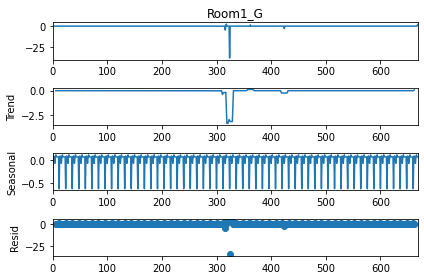

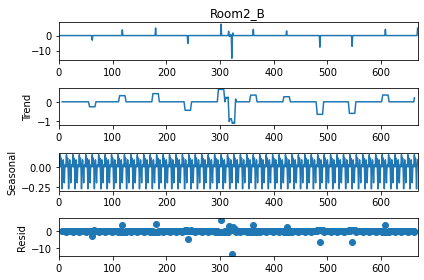

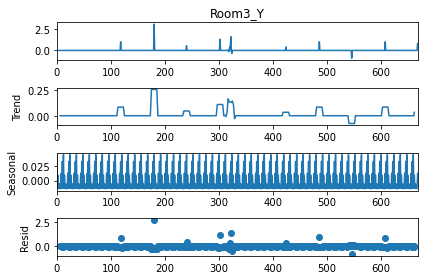

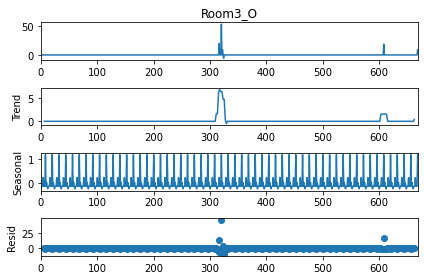

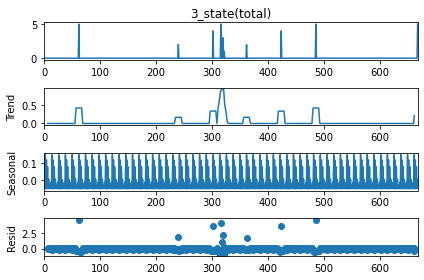

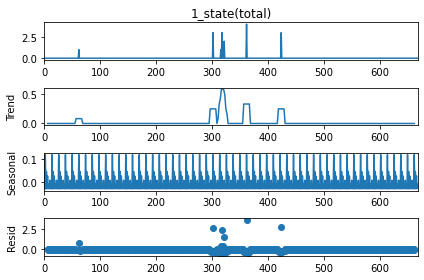

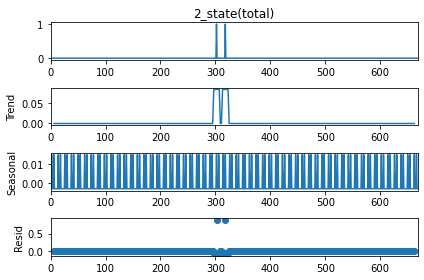

In [27]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming df_diff is your pandas DataFrame containing the differenced time series
# Manually reset the index
df_diff.reset_index(drop=True, inplace=True)

# Fill the first row of df_diff with zeros
df_diff.iloc[0] = df_diff.iloc[0].fillna(0)

# Assuming you have a date-time column in your original data, set it as the index
# If your date-time column is named "datetime_column", use the following line:
# df_diff.set_index("datetime_column", inplace=True)

# Perform seasonal decomposition for each variable in df_diff
decomposed_data = {}
for column in df_diff.columns:
    result = seasonal_decompose(df_diff[column], model="additive", period=12)  # Adjust the period as per your data frequency
    decomposed_data[column] = result

# Access the decomposed components for each variable
for column, result in decomposed_data.items():
    fig = result.plot()




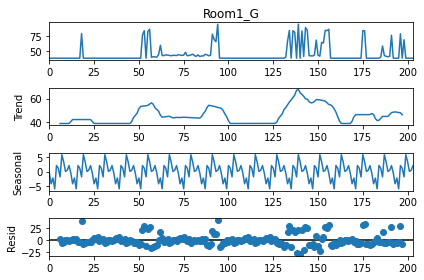

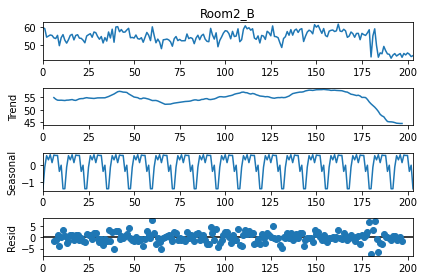

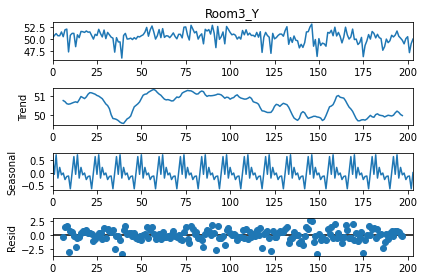

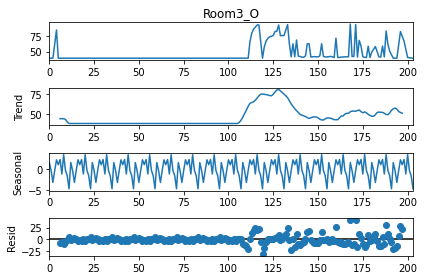

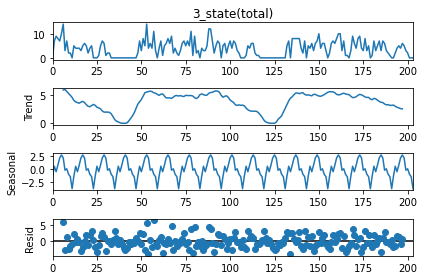

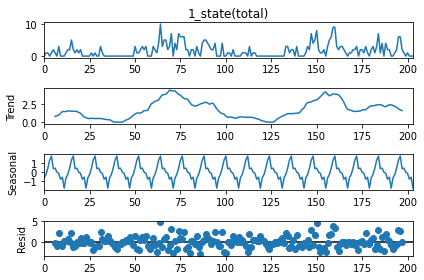

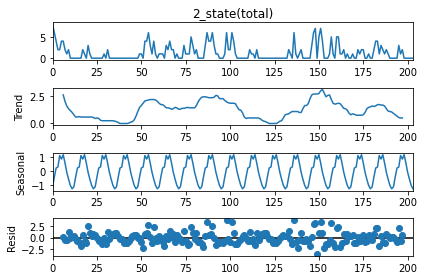

In [28]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming df_diff is your pandas DataFrame containing the differenced time series
# Manually reset the index
df.reset_index(drop=True, inplace=True)

# Fill the first row of df_diff with zeros
#df.iloc[0] = df.iloc[0].fillna(0)

# Assuming you have a date-time column in your original data, set it as the index
# If your date-time column is named "datetime_column", use the following line:
# df_diff.set_index("datetime_column", inplace=True)

# Perform seasonal decomposition for each variable in df_diff
decomposed_data = {}
for column in df.columns:
    result = seasonal_decompose(df[column], model="additive", period=12)  # Adjust the period as per your data frequency
    decomposed_data[column] = result

# Access the decomposed components for each variable
for column, result in decomposed_data.items():
    fig = result.plot()

In [32]:
trend = result.trend
seasonal = result.seasonal
residual = result.resid
print(trend)
print(seasonal)
print(residual)

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
199   NaN
200   NaN
201   NaN
202   NaN
203   NaN
Name: trend, Length: 204, dtype: float64
0     -1.095703
1     -0.392578
2      0.240234
3      0.310547
4      1.128255
         ...   
199    0.597005
200   -0.064453
201   -0.556641
202   -0.994141
203   -1.236328
Name: seasonal, Length: 204, dtype: float64
0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
199   NaN
200   NaN
201   NaN
202   NaN
203   NaN
Name: resid, Length: 204, dtype: float64


In [34]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming df_diff is your pandas DataFrame containing the differenced time series
# Manually reset the index
df.reset_index(drop=True, inplace=True)

# Assuming you have a date-time column in your original data, set it as the index
# If your date-time column is named "datetime_column", use the following line:
# df_diff.set_index("datetime_column", inplace=True)

# Perform seasonal decomposition for each variable in df_diff
decomposed_data = {}
for column in df.columns:
    result = seasonal_decompose(df[column], model="additive", period=12)  # Adjust the period as per your data frequency
    decomposed_data[column] = result

# Create dictionaries to store decomposed components for each variable
trend_components = {}
seasonal_components = {}
residual_components = {}

# Access the decomposed components for each variable
for column, result in decomposed_data.items():
    trend_components[column] = result.trend
    seasonal_components[column] = result.seasonal
    residual_components[column] = result.resid

# Now you can print any trend, seasonal, or residual component for any variable
# For example, to print the trend component for a variable named "your_column_name", use the following line:
# Print trend components for each column
for column, trend in trend_components.items():
    print(f"Trend component for {column}:\n")
    print(trend)
    print("\n----------\n")
    # Print seasonal components for each column
for column, seasonal in seasonal_components.items():
    print(f"Seasonal component for {column}:\n")
    print(seasonal)
    print("\n----------\n")

# Print residual components for each column
for column, residual in residual_components.items():
    print(f"Residual component for {column}:\n")
    print(residual)
    print("\n----------\n")



Trend component for Room1_G:

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
199   NaN
200   NaN
201   NaN
202   NaN
203   NaN
Name: trend, Length: 204, dtype: float64

----------

Trend component for Room2_B:

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
199   NaN
200   NaN
201   NaN
202   NaN
203   NaN
Name: trend, Length: 204, dtype: float64

----------

Trend component for Room3_Y:

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
199   NaN
200   NaN
201   NaN
202   NaN
203   NaN
Name: trend, Length: 204, dtype: float64

----------

Trend component for Room3_O:

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
199   NaN
200   NaN
201   NaN
202   NaN
203   NaN
Name: trend, Length: 204, dtype: float64

----------

Trend component for 3_state(total):

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
199   NaN
200   NaN
201   NaN
202   NaN
203   NaN
Name: trend, Length: 204, dtype: float64

----------

Trend component for 1_s

去掉Room3_O 开始进行因果检验


In [41]:
df_diff = df_diff.drop('Room3_O', axis=1)
df_diff.iloc[0] = df_diff.iloc[0].fillna(0)
print(df_diff)

     Room1_G  Room2_B  Room3_Y  3_state(total)  1_state(total)  2_state(total)
0        0.0     0.00     0.00             0.0             0.0             0.0
1        0.0    -0.30     0.50             7.0             1.0            -2.0
2        0.0    -4.75     0.40             2.0             0.0            -2.0
3        0.0     0.60    -0.45            -1.0            -1.0            -2.0
4        0.0     0.60     0.00            -1.0             1.0             0.0
..       ...      ...      ...             ...             ...             ...
199    -29.9    -0.80     1.10            -2.0            -1.0             0.0
200      0.0     1.10     0.40            -1.0             1.0             0.0
201      0.0    -0.70    -3.35            -2.0            -1.0             0.0
202      0.0    -1.30     1.90             0.0             0.0             0.0
203      0.0     0.50     0.95             0.0             0.0             0.0

[204 rows x 6 columns]


In [44]:
df_diff.to_csv("df_diff.csv")

In [46]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Assuming df_diff is your DataFrame

# Create pairs of variables for Granger causality tests
pairs = [('Room1_G', '1_state(total)'), ('Room2_B', '2_state(total)'), ('Room3_Y', '3_state(total)')]

for pair in pairs:
    # Take the two columns as a new DataFrame
    temp_df = df_diff[[pair[0], pair[1]]]

    # Apply Granger Causality test
    print(f"\nGranger Causality test for pair: {pair}")
    granger_test_results = grangercausalitytests(temp_df, maxlag=2, verbose=True)  # maxlag is set to 2, you can adjust this value



Granger Causality test for pair: ('Room1_G', '1_state(total)')

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7387  , p=0.0995  , df_denom=200, df_num=1
ssr based chi2 test:   chi2=2.7797  , p=0.0955  , df=1
likelihood ratio test: chi2=2.7609  , p=0.0966  , df=1
parameter F test:         F=2.7387  , p=0.0995  , df_denom=200, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6766  , p=0.1897  , df_denom=197, df_num=2
ssr based chi2 test:   chi2=3.4383  , p=0.1792  , df=2
likelihood ratio test: chi2=3.4094  , p=0.1818  , df=2
parameter F test:         F=1.6766  , p=0.1897  , df_denom=197, df_num=2

Granger Causality test for pair: ('Room2_B', '2_state(total)')

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0718  , p=0.7891  , df_denom=200, df_num=1
ssr based chi2 test:   chi2=0.0728  , p=0.7872  , df=1
likelihood ratio test: chi2=0.0728  , p=0.7873  , df=1
parameter F test:         F=0.0718  , p

调换方向，再次检验

In [49]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Assuming df_diff is your DataFrame

# Create pairs of variables for Granger causality tests
pairs = [('1_state(total)', 'Room1_G'), ('2_state(total)', 'Room2_B'), ('3_state(total)', 'Room3_Y')]

for pair in pairs:
    # Take the two columns as a new DataFrame
    temp_df_reverse = df_diff[[pair[0], pair[1]]]

    # Apply Granger Causality test
    print(f"\nGranger Causality test for pair: {pair}")
    granger_test_results_reverse = grangercausalitytests(temp_df_reverse, maxlag=2, verbose=True)  # maxlag is set to 2, you can adjust this value



Granger Causality test for pair: ('1_state(total)', 'Room1_G')

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3413  , p=0.5598  , df_denom=200, df_num=1
ssr based chi2 test:   chi2=0.3464  , p=0.5562  , df=1
likelihood ratio test: chi2=0.3461  , p=0.5563  , df=1
parameter F test:         F=0.3413  , p=0.5598  , df_denom=200, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5210  , p=0.5947  , df_denom=197, df_num=2
ssr based chi2 test:   chi2=1.0685  , p=0.5861  , df=2
likelihood ratio test: chi2=1.0657  , p=0.5869  , df=2
parameter F test:         F=0.5210  , p=0.5947  , df_denom=197, df_num=2

Granger Causality test for pair: ('2_state(total)', 'Room2_B')

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8159  , p=0.3675  , df_denom=200, df_num=1
ssr based chi2 test:   chi2=0.8281  , p=0.3628  , df=1
likelihood ratio test: chi2=0.8265  , p=0.3633  , df=1
parameter F test:         F=0.8159  , p

证明我们需要用非线性的来进行预测了

In [55]:
#纯随机性检验（白噪声检验）最好放到因果检验之前
from statsmodels.stats.diagnostic import acorr_ljungbox

# Assuming `df` is your DataFrame and it contains multiple columns
for column in df.columns:
    series = df[column]
    p_value = acorr_ljungbox(series, lags=1)
    print(f"Column: {column}, p-value: {p_value}")



Column: Room1_G, p-value:      lb_stat  lb_pvalue
1  23.640162   0.000001
Column: Room2_B, p-value:     lb_stat     lb_pvalue
1  98.17652  3.827010e-23
Column: Room3_Y, p-value:      lb_stat  lb_pvalue
1  10.753365   0.001041
Column: Room3_O, p-value:      lb_stat     lb_pvalue
1  88.189405  5.947765e-21
Column: 3_state(total), p-value:      lb_stat     lb_pvalue
1  44.437606  2.625942e-11
Column: 1_state(total), p-value:      lb_stat     lb_pvalue
1  53.044216  3.261239e-13
Column: 2_state(total), p-value:      lb_stat     lb_pvalue
1  49.122662  2.404462e-12


In [57]:
pip install keras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 652.1 kB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [60]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.1 MB/s eta 0:00:0000:0100:04
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 4.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 4.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 4.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 2.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 721.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 3.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.8/181.8 kB 2.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import pandas as pd

# 分离特征和目标
X = df_diff[['1_state(total)', '2_state(total)', '3_state(total)']].values
y = df_diff[['Room1_G', 'Room2_B', 'Room3_Y']].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化模型
rf = RandomForestRegressor(n_estimators=100)
knn = KNeighborsRegressor(n_neighbors=3)

# 拟合模型
rf.fit(X_train, y_train)
knn.fit(X_train, y_train)

# 进行预测
rf_pred = rf.predict(X_test)
knn_pred = knn.predict(X_test)

# 打印MSE
print("MSE of Random Forest: ", mean_squared_error(y_test, rf_pred))
print("MSE of KNN: ", mean_squared_error(y_test, knn_pred))

# 对于LSTM，我们需要修改数据的形状
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 构建模型
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(None, X_train.shape[1])))
model.add(LSTM(32, return_sequences=False))  # 修改这里
model.add(Dense(y_train.shape[1]))

# 编译模型
model.compile(loss='mean_squared_error', optimizer='adam')

# 拟合模型
model.fit(X_train_lstm, y_train, epochs=10, batch_size=32)

# 进行预测
lstm_pred = model.predict(X_test_lstm)

# 打印MSE
print("MSE of LSTM: ", mean_squared_error(y_test, lstm_pred))


MSE of Random Forest:  183.61092692715337
MSE of KNN:  177.339482836495
Epoch 1/10
6/6 [==============================] - 2s 4ms/step - loss: 77.8517
Epoch 2/10
6/6 [==============================] - 0s 4ms/step - loss: 77.8152
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 77.7930
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 77.7834
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 77.7676
Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 77.7423
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 77.7146
Epoch 8/10
6/6 [==============================] - 0s 4ms/step - loss: 77.6809
Epoch 9/10
6/6 [==============================] - 0s 4ms/step - loss: 77.6445
Epoch 10/10
2/2 [==============================] - 0s 3ms/step
MSE of LSTM:  143.45981681515363


In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import pandas as pd

# ... (rest of your code to prepare the data)

# Initialize models
rf = RandomForestRegressor(n_estimators=100)
knn = KNeighborsRegressor(n_neighbors=3)

# Perform cross-validation for Random Forest
rf_cv_scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, rf_pred)
    rf_cv_scores.append(mse)
rf_mse_cv_mean = np.mean(rf_cv_scores)
print("MSE of Random Forest (Cross-Validation):", rf_mse_cv_mean)

# Perform cross-validation for KNN
knn_cv_scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    mse = mean_squared_error(y_test, knn_pred)
    knn_cv_scores.append(mse)
knn_mse_cv_mean = np.mean(knn_cv_scores)
print("MSE of KNN (Cross-Validation):", knn_mse_cv_mean)

# ... (rest of your LSTM code)

# Function to create the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(None, X.shape[1])))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

lstm_cv_scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_lstm):
    X_train, X_test = X_lstm[train_index], X_lstm[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_lstm_model()
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    lstm_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, lstm_pred)
    lstm_cv_scores.append(mse)
lstm_mse_cv_mean = np.mean(lstm_cv_scores)
print("MSE of LSTM (Cross-Validation):", lstm_mse_cv_mean)


MSE of Random Forest (Cross-Validation): 113.53631888146576
MSE of KNN (Cross-Validation): 116.53298693541103
2/2 [==============================] - 0s 3ms/step
MSE of LSTM (Cross-Validation): 91.15840545499866


In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming you have already trained and tested the models

# RMSE for Random Forest
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
print("RMSE of Random Forest:", rf_rmse)

# MAE for Random Forest
rf_mae = mean_absolute_error(y_test, rf_pred)
print("MAE of Random Forest:", rf_mae)

# R-squared for Random Forest
rf_r2 = r2_score(y_test, rf_pred)
print("R-squared of Random Forest:", rf_r2)

# RMSE for KNN
knn_rmse = np.sqrt(mean_squared_error(y_test, knn_pred))
print("RMSE of KNN:", knn_rmse)

# MAE for KNN
knn_mae = mean_absolute_error(y_test, knn_pred)
print("MAE of KNN:", knn_mae)

# R-squared for KNN
knn_r2 = r2_score(y_test, knn_pred)
print("R-squared of KNN:", knn_r2)

# Assuming you have already trained and tested the LSTM model

# RMSE for LSTM
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
print("RMSE of LSTM:", lstm_rmse)

# MAE for LSTM
lstm_mae = mean_absolute_error(y_test, lstm_pred)
print("MAE of LSTM:", lstm_mae)

# R-squared for LSTM
lstm_r2 = r2_score(y_test, lstm_pred)
print("R-squared of LSTM:", lstm_r2)


RMSE of Random Forest: 10.159891749348414
MAE of Random Forest: 4.741434163852532
R-squared of Random Forest: -0.3181786015498769
RMSE of KNN: 10.809842373024209
MAE of KNN: 5.146527777777778
R-squared of KNN: -0.38374571704840194
RMSE of LSTM: 10.188680789937544
MAE of LSTM: 3.914646839717946
R-squared of LSTM: -0.01808096425583276


NameError: name 'y_test' is not defined